## Automated Eval: Question-Answering and Person Biography Generation

This script demonstrates how to run automated evaluation of LMs generating long-form paragraphs---which may or may not contain statements of confidence---using off-the-shelf question-answering datasets, as well as on a person biography generation task.

In [ ]:
cd ..

First, you should make sure you have set your OpenAI and Anthropic API keys. OpenAI keys are used for GPT-4 baselines, while Anthropic keys are used for the evaluation framework with Claude.

```bash
export OPENAI_API_KEY=sk-...
export ANTHROPIC_API_KEY=sk-...
```

### Question-Answering Simulated Evaluation

Below, we provide functions to run automated evaluation with all baselines and datasets (TriviaQA, Jeopardy, SciQ, BioASQ Task B).
 
We also include example QA evaluation runscripts at `./examples/qa_auto_eval_scripts` to run evals on TriviaQA or Jeopardy, with all arguments filled in other than:
- `paragraph_generator_model_name`: needs to be specified for Llama-based baselines, but not GPT-4 baselines
- `dataset_name`: `trivia_qa` or `jeopardy`
- `max_n_examples`: provide if you want to limit the size of the eval set. Otherwise, we run on the full test set (~10k examples)

For example, you can run LC SFT automated evaluation on TriviaQA with 1000 examples as follows:
```bash
bash ./examples/qa_auto_eval_scripts/any_confidence_finetuned.sh lc_sft trivia_qa 1000
```
where `lc_sft` should point to the path of the LC SFT checkpoint in the object `constants.SHORT_NAME_TO_MODEL_PATH`.

Similarly, you could run GPT-4 0-shot evaluation on Jeopardy with 10 examples as follows:
```bash
bash ./examples/qa_auto_eval_scripts/gpt4_0shot.sh jeopardy 10
```
since no model path needs to be specified for the GPT-4 baselines. 

In [2]:
# Tuples have format (model_name, paragraph_generation_prompt, display_name)

NON_CONFIDENCE_MODEL_AND_PARAGRAPH_GENERATION_PROMPT_QA_EVAL = [
    # Finetuned
    ("claude_distill", "generate_paragraphs_llama_finetuned", "Claude Distill"),
    ("factuality_sft", "generate_paragraphs_llama_finetuned", "Factuality SFT"),
    ("factuality_rl", "generate_paragraphs_llama_finetuned", "Factuality RL"),
    
    # Prompted
    ("llama-2-7b-chat-hf", "generate_paragraphs_llama_chat_0shot", "Llama 2 Chat 7B"),
    ("llama-2-7b-hf", "generate_paragraphs_llama_trivia_qa_icl_8shot", "ICL 8-Shot"),
    ("gpt-4-1106-preview", "generate_paragraphs_chatml_0shot", "GPT-4 0-Shot"),
    ("gpt-4-1106-preview", "generate_paragraphs_llama_trivia_qa_icl_8shot", "GPT-4 ICL 8-Shot")
]

CONFIDENCE_MODEL_AND_PARAGRAPH_GENERATION_PROMPT_QA_EVAL = [
    # Finetuned
    ("lc_sft", "generate_paragraphs_llama_finetuned", "LC SFT"),
    ("lc_rl", "generate_paragraphs_llama_finetuned", "LC RL"),
    
    # Prompted
    ("llama-2-7b-hf", "generate_paragraphs_llama_trivia_qa_summary_icl_8shot", "Summary ICL 8-Shot"),
    ("gpt-4-1106-preview", "generate_paragraphs_chatml_jafu_0shot", "GPT-4 JAFU 0-Shot"),
    ("gpt-4-1106-preview", "generate_paragraphs_gpt4_trivia_qa_summary_icl_8shot", "GPT-4 Summary ICL 8-Shot")
]

SciQ and BioASQ include specialized scientific/biomedical questions. Therefore, we opt for the stronger Claude 3 Opus model to serve as the semantic equivalence checker; the rest of the evaluation framework is identical to TriviaQA and Jeopardy.

Refer to Appendix D of the paper for more details.

In [3]:
# You can specify these depending on your setup. MAX_EXAMPLES = None runs on the full test set.

from linguistic_calibration.constants import DEFAULT_OUTPUT_DIR

QA_OUTPUT_DIR = DEFAULT_OUTPUT_DIR
QA_MAX_EXAMPLES = 200
QA_DATASETS = ["trivia_qa", "jeopardy", "sciq", "bioasq"]
QA_DATASET_TO_SEMANTIC_EQUIVALENCE_MODEL_NAME = {
    "trivia_qa": "claude-2.0",
    "jeopardy": "claude-2.0",
    "sciq": "claude-3-opus-20240229",
    "bioasq": "claude-3-opus-20240229"
}
QA_DATASET_TO_SEMANTIC_EQUIVALENCE_PROMPT = {
    "trivia_qa": "eval/check_semantic_equivalence_10shot_batch10",
    "jeopardy": "eval/check_semantic_equivalence_10shot_batch10",
    "sciq": "eval/check_semantic_equivalence_10shot_batch10_claude_chat",
    "bioasq": "eval/check_semantic_equivalence_10shot_batch10_claude_chat"
}

In [ ]:
from examples.qa_automated_eval import main as qa_auto_eval_main

# Run all QA automated evaluations. These save results to disk in the QA_OUTPUT_DIR.
for dataset in QA_DATASETS:
    for model_name, paragraph_generation_prompt, _ in NON_CONFIDENCE_MODEL_AND_PARAGRAPH_GENERATION_PROMPT_QA_EVAL:
        print("-"*80)
        print(f"QA Auto Eval: {model_name} with prompt {paragraph_generation_prompt} on {dataset}.")
        qa_auto_eval_main(
            paragraph_generator_model_name=model_name,
            paragraph_generation_prompt=paragraph_generation_prompt,
            semantic_equivalence_prompt=QA_DATASET_TO_SEMANTIC_EQUIVALENCE_PROMPT[dataset],
            semantic_equivalence_model_name=QA_DATASET_TO_SEMANTIC_EQUIVALENCE_MODEL_NAME[dataset],
            dataset_name=dataset,
            dataset_split="test",
            max_n_examples=QA_MAX_EXAMPLES,
            output_root_dir=QA_OUTPUT_DIR,
            skip_forecast_probs=True,
            per_device_batch_size=4,
            seed=1
        )
        
    for model_name, paragraph_generation_prompt, _ in CONFIDENCE_MODEL_AND_PARAGRAPH_GENERATION_PROMPT_QA_EVAL:
        print("-"*80)
        print(f"QA Auto Eval: {model_name} with prompt {paragraph_generation_prompt} on {dataset}.")
        qa_auto_eval_main(
            paragraph_generator_model_name=model_name,
            paragraph_generation_prompt=paragraph_generation_prompt,
            semantic_equivalence_prompt=QA_DATASET_TO_SEMANTIC_EQUIVALENCE_PROMPT[dataset],
            semantic_equivalence_model_name=QA_DATASET_TO_SEMANTIC_EQUIVALENCE_MODEL_NAME[dataset],
            dataset_name=dataset,
            dataset_split="test",
            max_n_examples=QA_MAX_EXAMPLES,
            output_root_dir=QA_OUTPUT_DIR,
            per_device_batch_size=4,
            seed=1
        )

### Person Biography Generation - Per-Claim Evaluation Metric

Similarly, we provide functions below to run automated evaluations on the Person Biography Generation task. This metric is inspired by FactScore (Min et al.) and measures the calibration and accuracy of generated biographies at the per-claim level.

The biography generation eval runscripts are at `./examples/biography_generation_eval_scripts`, with all arguments filled in other than:
- `paragraph_generator_model_name`: needs to be specified for Llama-based baselines, but not GPT-4 baselines
- `max_n_examples`: provide if you want to limit the number of examples evaluated. Otherwise, we run on the full test set (500 entities)

For example, you can run LC SFT automated evaluation with 10 entities as follows:
```bash
bash ./examples/biography_generation_eval_scripts/any_confidence_finetuned.sh lc_sft 10
```
where `lc_sft` should point to the path of the LC SFT checkpoint in `constants.SHORT_NAME_TO_MODEL_PATH`.

Similarly, you could run GPT-4 0-shot evaluation with 10 entities as follows:
```bash
bash ./examples/biography_generation_eval_scripts/gpt4_0shot.sh 10
```
since no model path needs to be specified for the GPT-4 baselines. 

Please cite FactScore if you use this evaluation metric:
```bibtex
@inproceedings{ factscore,
    title={ {FActScore}: Fine-grained Atomic Evaluation of Factual Precision in Long Form Text Generation },
    author={ Min, Sewon and Krishna, Kalpesh and Lyu, Xinxi and Lewis, Mike and Yih, Wen-tau and Koh, Pang Wei and Iyyer, Mohit and Zettlemoyer, Luke and Hajishirzi, Hannaneh },
    year={ 2023 },
    booktitle = { EMNLP },
    url={ https://arxiv.org/abs/2305.14251 }
}
```

### FactScore Database Download

To run the FactScore metric, we need to download a Wikipedia retrieval database. This currently doesn't work programmatically because of a permissions issue (https://github.com/shmsw25/FActScore/issues/40) but we work around it using the `gdown` package.

In [ ]:
pip install gdown

In [ ]:
from linguistic_calibration.constants import FACTSCORE_CACHE_PATH

# Download the FactScore database
!cd $FACTSCORE_CACHE_PATH && gdown --id "1mekls6OGOKLmt7gYtHs0WGf5oTamTNat"

In [31]:
NON_CONFIDENCE_MODEL_AND_PARAGRAPH_GENERATION_PROMPT_BIOGRAPHY_GEN_EVAL = [
    # Finetuned
    ("claude_distill", "generate_paragraphs_llama_finetuned", "Claude Distill"),
    ("factuality_sft", "generate_paragraphs_llama_finetuned", "Factuality SFT"),
    ("factuality_rl", "generate_paragraphs_llama_finetuned", "Factuality RL"),
        
    # Prompted
    ("llama-2-7b-chat-hf", "generate_paragraphs_llama_chat_0shot", "Llama 2 Chat 7B"),
    ("gpt-4-1106-preview", "generate_paragraphs_chatml_0shot", "GPT-4 0-Shot"),
]

CONFIDENCE_MODEL_AND_PARAGRAPH_GENERATION_PROMPT_BIOGRAPHY_GEN_EVAL = [
    # Finetuned
    ("lc_sft", "generate_paragraphs_llama_finetuned", "LC SFT"),
    ("lc_rl", "generate_paragraphs_llama_finetuned", "LC RL"),
    
    # Prompted
    ("gpt-4-1106-preview", "generate_paragraphs_chatml_jafu_0shot", "GPT-4 JAFU 0-Shot")
]

In [32]:
BIO_GEN_OUTPUT_DIR = DEFAULT_OUTPUT_DIR
BIO_GEN_MAX_EXAMPLES = 20

In [ ]:
from examples.biography_generation_automated_eval import main as biography_generation_auto_eval_main

# Run all biography generation automated evaluations. These save results to disk in the BIO_GEN_OUTPUT_DIR.
for model_name, paragraph_generation_prompt, _ in NON_CONFIDENCE_MODEL_AND_PARAGRAPH_GENERATION_PROMPT_BIOGRAPHY_GEN_EVAL:
    print("-"*80)
    print(f"Biography Generation Auto Eval: model {model_name}, prompt {paragraph_generation_prompt}.") 
    biography_generation_auto_eval_main(
        paragraph_generator_model_name=model_name,
        paragraph_generation_prompt=paragraph_generation_prompt,
        claim_decomposition_prompt="biography_generation_eval/nonconfidence_decompose_claims_claude_8shot",
        dataset_split="test",
        max_n_examples=BIO_GEN_MAX_EXAMPLES,
        output_root_dir=BIO_GEN_OUTPUT_DIR,
        per_device_batch_size=4,
        seed=1
    )
    
for model_name, paragraph_generation_prompt, _ in CONFIDENCE_MODEL_AND_PARAGRAPH_GENERATION_PROMPT_BIOGRAPHY_GEN_EVAL:
    print("-"*80)
    print(f"Biography Generation Auto Eval: model {model_name}, prompt {paragraph_generation_prompt}.")
    biography_generation_auto_eval_main(
        paragraph_generator_model_name=model_name,
        paragraph_generation_prompt=paragraph_generation_prompt,
        claim_decomposition_prompt="biography_generation_eval/confidence_decompose_claims_claude_8shot",
        claim_uncertainty_filter_prompt="biography_generation_eval/confidence_filter_claude_1shot",
        dataset_split="test",
        max_n_examples=BIO_GEN_MAX_EXAMPLES,
        output_root_dir=BIO_GEN_OUTPUT_DIR,
        per_device_batch_size=4,
        seed=1
    )

## Visualize Auto Eval Results

Below we provide code to generate pd.DataFrame results and two types of plots:
- Accuracy versus ECE frontiers
- Reliability diagrams, which visualize model calibration

First, we process raw results into metrics.

In [ ]:
from linguistic_calibration.auto_annotations.plot_utils import load_eval_results, load_qa_non_confidence_results_default_eval_hypers, load_qa_confidence_results_default_eval_hypers, load_factscore_nonconfidence_results_default_eval_hypers, load_factscore_confidence_results_default_eval_hypers

print("Loading QA results...")
NON_CONFIDENCE_QA_RESULTS = load_eval_results(
    eval_models=NON_CONFIDENCE_MODEL_AND_PARAGRAPH_GENERATION_PROMPT_QA_EVAL,
    load_result_fn=load_qa_non_confidence_results_default_eval_hypers,
    datasets=QA_DATASETS,
    results_path=QA_OUTPUT_DIR,
    n_examples=QA_MAX_EXAMPLES
)
CONFIDENCE_QA_RESULTS = load_eval_results(
    eval_models=CONFIDENCE_MODEL_AND_PARAGRAPH_GENERATION_PROMPT_QA_EVAL,
    load_result_fn=load_qa_confidence_results_default_eval_hypers,
    datasets=QA_DATASETS,
    results_path=QA_OUTPUT_DIR,
    n_examples=QA_MAX_EXAMPLES
)

print("Loading FactScore results...")
NON_CONFIDENCE_FACTSCORE_RESULTS = load_eval_results(
    eval_models=NON_CONFIDENCE_MODEL_AND_PARAGRAPH_GENERATION_PROMPT_BIOGRAPHY_GEN_EVAL,
    load_result_fn=load_factscore_nonconfidence_results_default_eval_hypers,
    datasets=["factscore"],
    results_path=BIO_GEN_OUTPUT_DIR,
    n_examples=BIO_GEN_MAX_EXAMPLES
)
CONFIDENCE_FACTSCORE_RESULTS = load_eval_results(
    eval_models=CONFIDENCE_MODEL_AND_PARAGRAPH_GENERATION_PROMPT_BIOGRAPHY_GEN_EVAL,
    load_result_fn=load_factscore_confidence_results_default_eval_hypers,
    datasets=["factscore"],
    results_path=BIO_GEN_OUTPUT_DIR,
    n_examples=BIO_GEN_MAX_EXAMPLES
)

In [ ]:
from linguistic_calibration.auto_annotations.process_eval_results import get_metrics_for_non_confidence_baseline, get_metrics_for_confidence_baseline, get_metrics_for_factscore_nonconfidence_results, get_metrics_for_factscore_confidence_results

print("Computing QA metrics...")
NON_CONFIDENCE_QA_METRICS = {
    key: get_metrics_for_non_confidence_baseline(df_tuple, key)
    for key, df_tuple in NON_CONFIDENCE_QA_RESULTS.items()
}
CONFIDENCE_QA_METRICS = {
    key: get_metrics_for_confidence_baseline(df_tuple, key)
    for key, df_tuple in CONFIDENCE_QA_RESULTS.items()
}

print("Computing FactScore metrics...")
NON_CONFIDENCE_FACTSCORE_METRICS = {
    key: get_metrics_for_factscore_nonconfidence_results(df, key)
    for key, df in NON_CONFIDENCE_FACTSCORE_RESULTS.items()
}
CONFIDENCE_FACTSCORE_METRICS = {
    key: get_metrics_for_factscore_confidence_results(df, key)
    for key, df in CONFIDENCE_FACTSCORE_RESULTS.items()
}

### Now, we can construct results dataframes and visualize the results.

In [7]:
# Construct results DFs
from linguistic_calibration.auto_annotations.plot_utils import get_results_df_given_methods_to_display

METRICS_DICTS_TO_USE_QA = [NON_CONFIDENCE_QA_METRICS, CONFIDENCE_QA_METRICS]
METRICS_DICTS_TO_USE_FACTSCORE = [NON_CONFIDENCE_FACTSCORE_METRICS, CONFIDENCE_FACTSCORE_METRICS]

results_df_qa = get_results_df_given_methods_to_display(methods_to_display=None, metric_dicts_to_use=METRICS_DICTS_TO_USE_QA)
results_df_factscore = get_results_df_given_methods_to_display(methods_to_display=None, metric_dicts_to_use=METRICS_DICTS_TO_USE_FACTSCORE)

In [ ]:
results_df_qa[['method', 'dataset', 'accuracy', 'ece']]

In [ ]:
results_df_factscore[['method', 'dataset', 'pooled_proportion_supported', 'pooled_ece']]

### Make plots pretty:

In [ ]:
from linguistic_calibration.auto_annotations.plot_utils import set_default_matplotlib_constants
from IPython.display import set_matplotlib_formats

# Make plots pretty
set_default_matplotlib_constants()
set_matplotlib_formats('retina')

### Accuracy-vs-ECE Frontier Plots:

Plotting for trivia_qa


/juice5/u/nband/workspace/lc/src/linguistic_calibration/auto_annotations/plot_utils.py:121: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


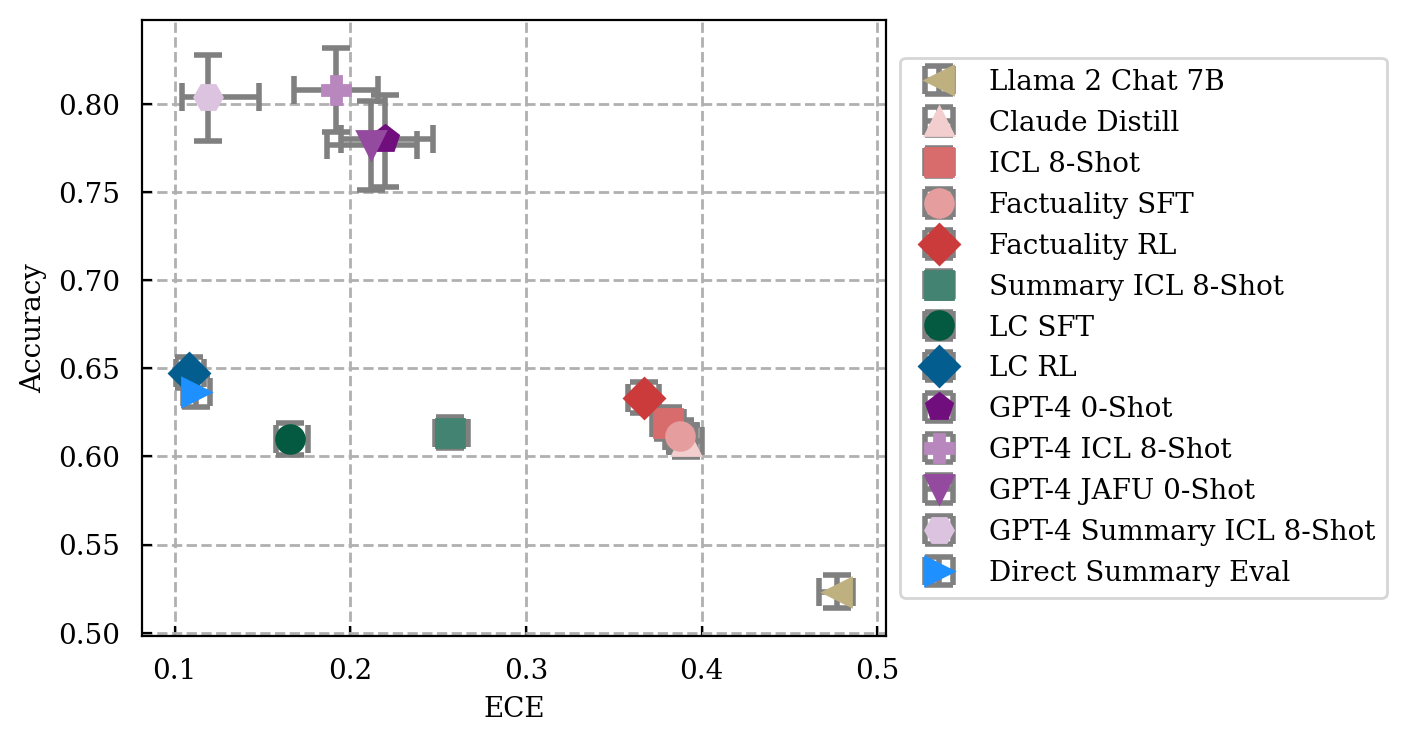

--------------------------------------------------------------------------------
Plotting for jeopardy


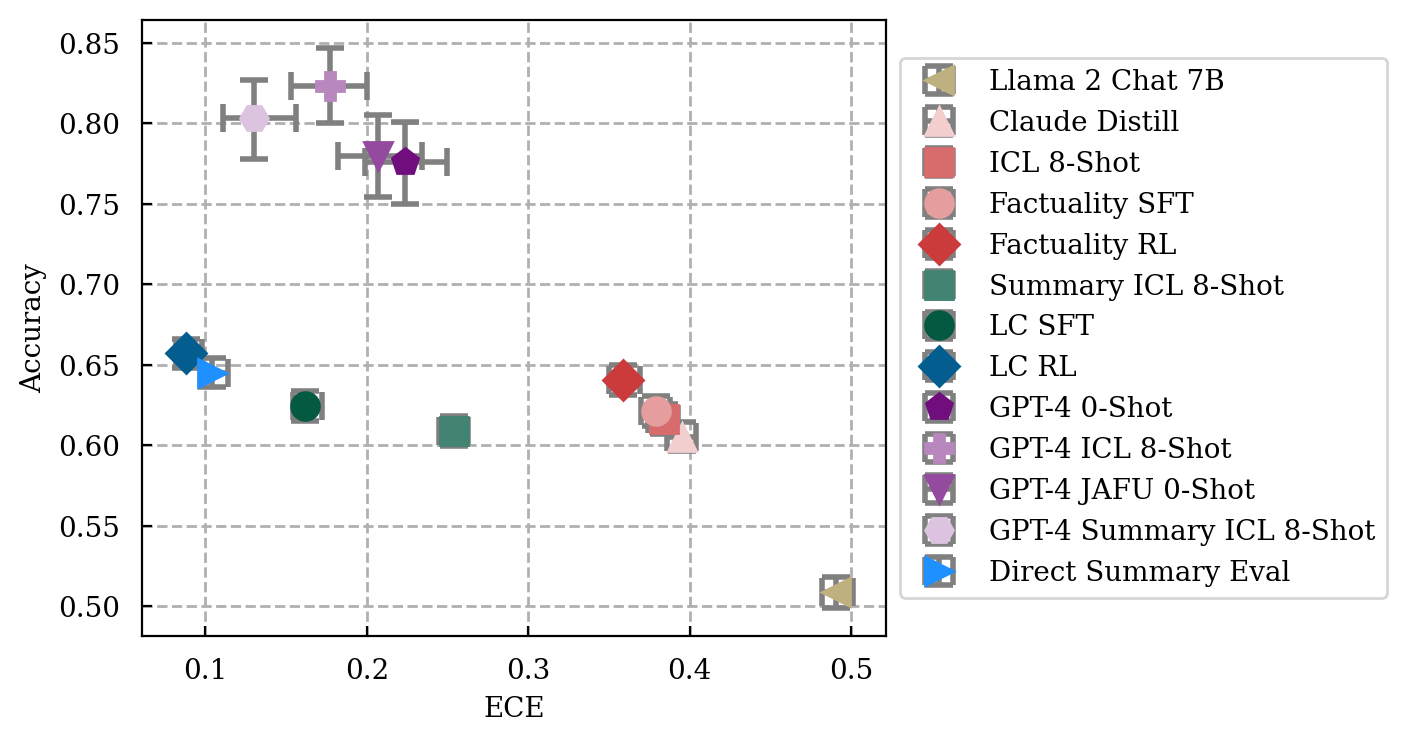

--------------------------------------------------------------------------------
Plotting for sciq


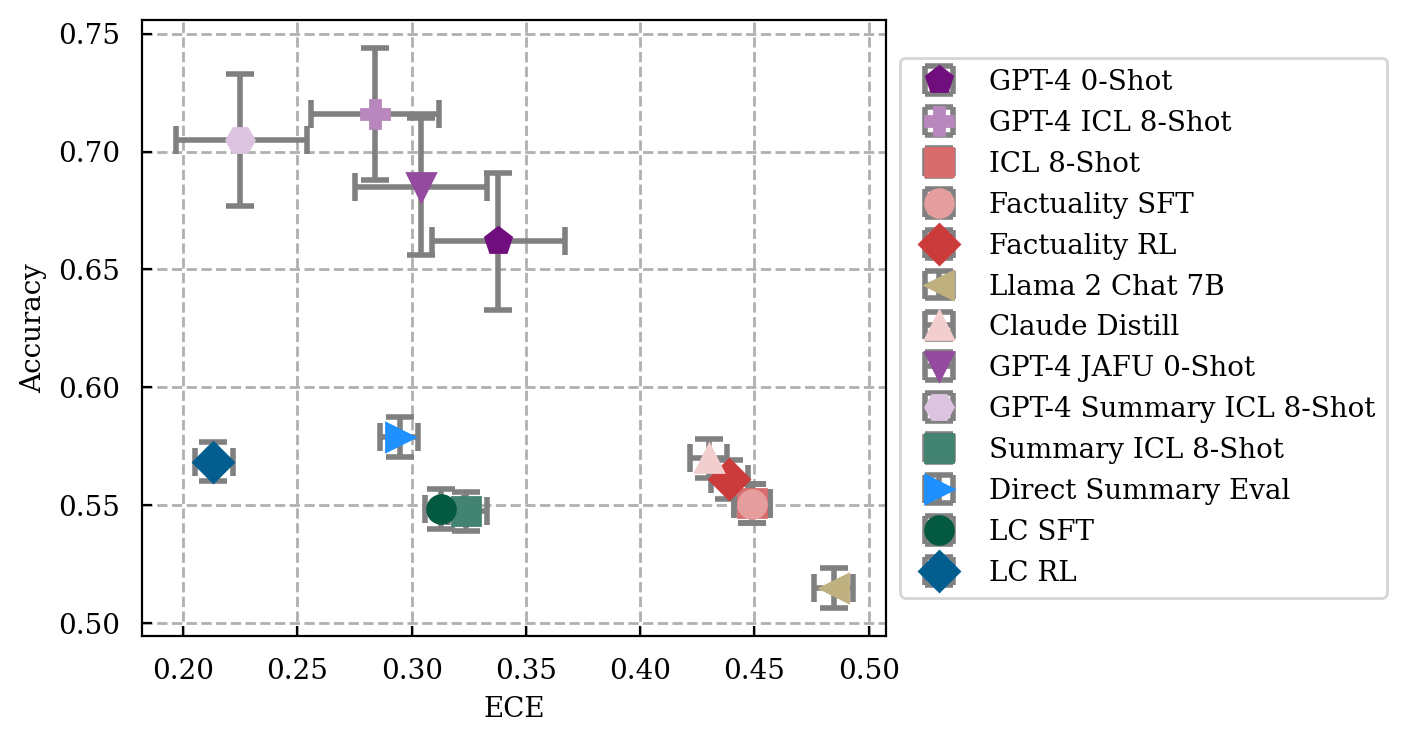

--------------------------------------------------------------------------------
Plotting for bioasq


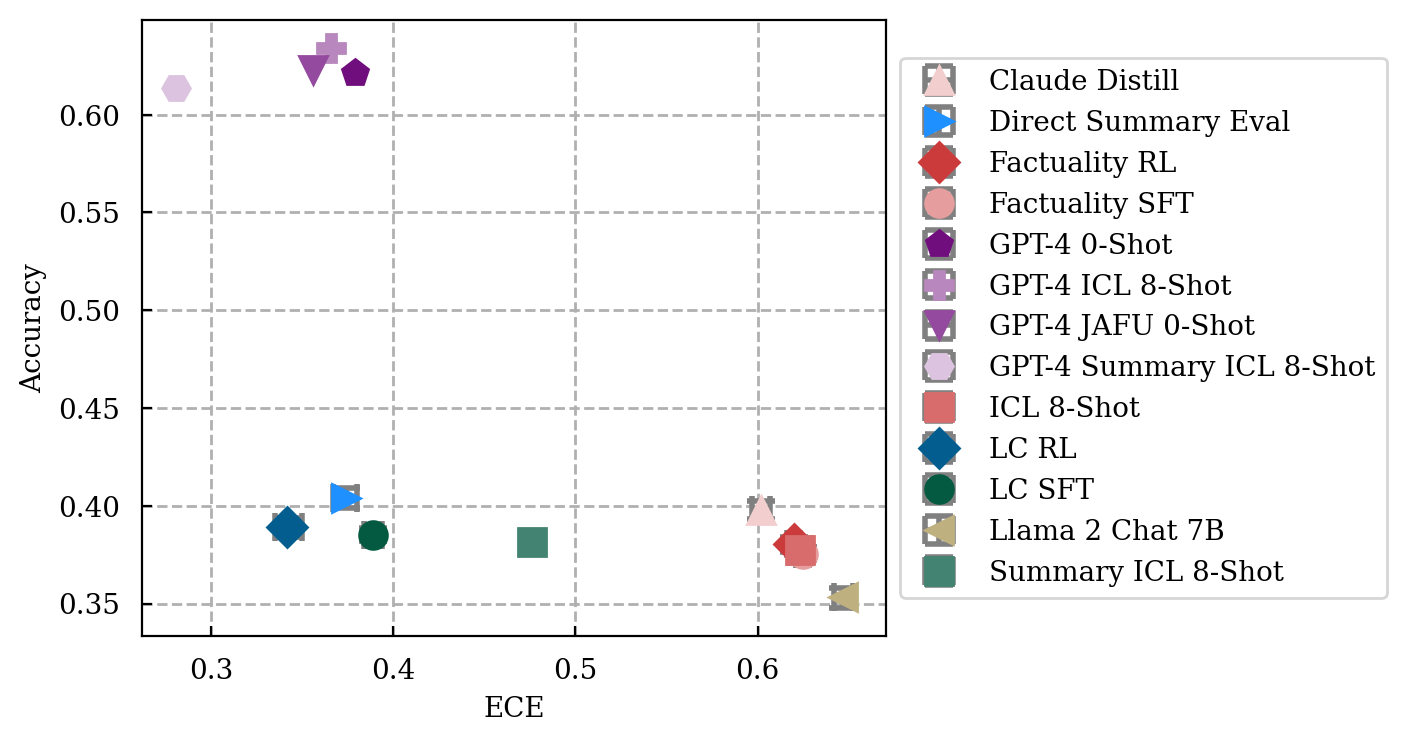

--------------------------------------------------------------------------------
Plotting for factscore


/juice5/u/nband/workspace/lc/src/linguistic_calibration/auto_annotations/plot_utils.py:162: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


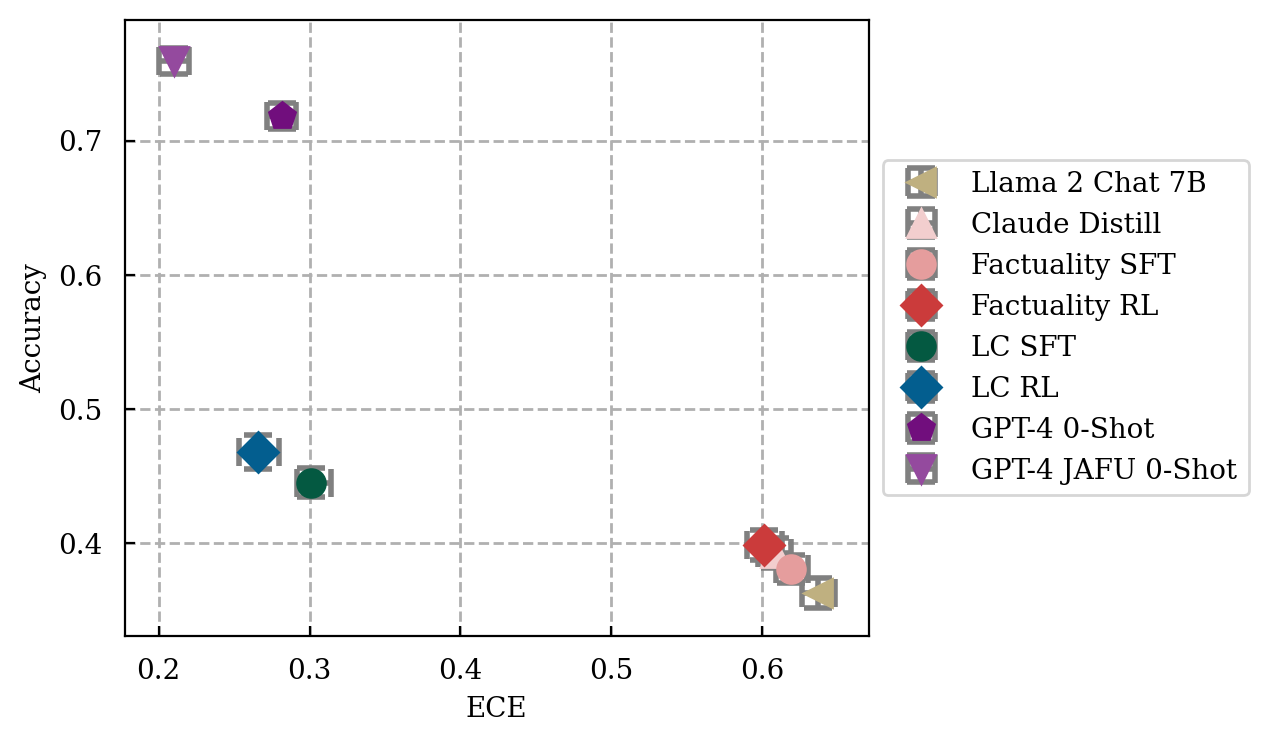

--------------------------------------------------------------------------------


In [6]:
import pandas as pd
from linguistic_calibration.auto_annotations.plot_utils import plot_qa_frontiers, plot_factscore_frontiers


# Optionally, load our paper results
DISPLAY_CACHED_RESULTS = True

if DISPLAY_CACHED_RESULTS:
    results_df_qa_paper = pd.read_csv("examples/qa_results.csv")
    results_df_factscore_paper = pd.read_csv("examples/biography_generation_results.csv")
    plot_qa_frontiers(QA_DATASETS, results_df_qa_paper)
    plot_factscore_frontiers(["factscore"], results_df_factscore_paper)
else:
    plot_qa_frontiers(QA_DATASETS, results_df_qa)
    plot_factscore_frontiers(["factscore"], results_df_factscore)

### Reliability Diagrams

In [ ]:
import numpy as np
from linguistic_calibration.auto_annotations.plot_utils import set_reliability_diagram_constants, plot_reliability_diagram


set_reliability_diagram_constants()

QA_RELIABILITY_COLUMNS = [
    'bin_accuracies',
    'bin_confidences',
    'bin_counts',
    'ece'
]
FACTSCORE_RELIABILITY_COLUMNS = [
    'pooled_bin_accuracies',
    'pooled_bin_confidences',
    'pooled_bin_counts',
    'pooled_ece'
]

for dataset_list, results_df, metrics_dict, reliability_columns in zip(
    [QA_DATASETS, ["factscore"]],
    [results_df_qa, results_df_factscore],
    [CONFIDENCE_QA_METRICS, CONFIDENCE_FACTSCORE_METRICS],
    [QA_RELIABILITY_COLUMNS, FACTSCORE_RELIABILITY_COLUMNS]
):
    for dataset in dataset_list:
        filtered_df = results_df[results_df['dataset'] == dataset]
            
        for method in filtered_df['method'].unique():
            try:
                metrics = metrics_dict[(method, dataset)]
            except:
                continue
                
            print(f"Plotting for {dataset}, {method}")
    
            accuracies_arr = np.array(metrics[reliability_columns[0]])
            confidences_arr = np.array(metrics[reliability_columns[1]])
            counts_arr = np.array(metrics[reliability_columns[2]])
            ece = metrics[reliability_columns[3]]
            
            plot_reliability_diagram(
                accuracies_arr,
                confidences_arr,
                counts_arr,
                ece,
                model_name=method)
            
            print("--"*40)